<a href="https://colab.research.google.com/github/Englios/Englios/blob/main/Adversarial_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 1 Adversarial Robustness

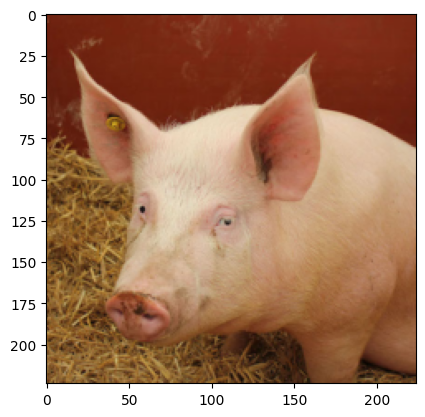

In [36]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# read the image, resize to 224 and convert to PyTorch Tensor
cat_img = Image.open("pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
cat_tensor = preprocess(cat_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(cat_tensor[0].numpy().transpose(1,2,0))

In [37]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images,
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [38]:
pred=model(norm(cat_tensor))

In [39]:
import json
with open("imagenet_class_index.json") as f:
  imagenet_classes={int(i):x[1] for i,x in json.load(f).items()}

print(imagenet_classes[pred.max(dim=1)[1].item()])

hog


In [40]:
print(nn.CrossEntropyLoss()(model(norm(cat_tensor)),torch.LongTensor([341])).item())

0.003882253309711814


In [41]:
import torch.optim as optim
epsilon=2./255

delta=torch.zeros_like(cat_tensor,requires_grad=True)
opt=optim.SGD([delta],lr=1e-1)


for t in range(30):
  pred=model(norm(cat_tensor+delta))
  loss=-nn.CrossEntropyLoss()(pred,torch.LongTensor([341]))
  if t%5 ==0:
    print(t,loss.item())

  opt.zero_grad()
  loss.backward()
  opt.step()
  delta.data.clamp_(-epsilon,epsilon) #clip data

print('True class probability',nn.Softmax(dim=1)(pred)[0,341].item())

0 -0.003882253309711814
5 -0.006934741511940956
10 -0.015805913135409355
15 -0.0799558088183403
20 -11.142181396484375
25 -13.397157669067383
True class probability 1.038025061461667e-06


In [42]:
max_class=pred.max(dim=1)[1].item()

print("Predicted Class: ",imagenet_classes[max_class])
print("Predicted Probability: ",nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted Class:  wombat
Predicted Probability:  0.9997883439064026


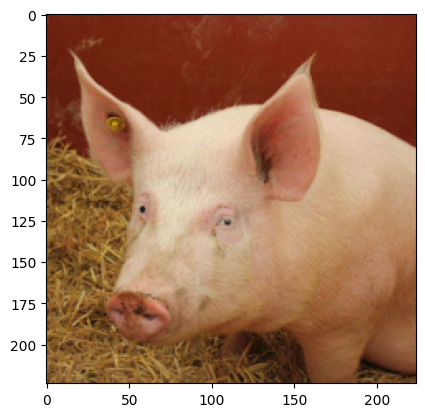

In [43]:
plt.imshow((cat_tensor+delta)[0].detach().numpy().transpose(1,2,0))

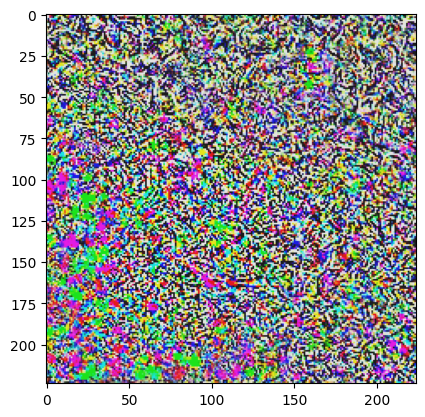

In [44]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

In [45]:
delta=torch.zeros_like(cat_tensor,requires_grad=True)
opt=optim.SGD([delta],lr=5e-3)

for t in range(100):
  pred=model(norm(cat_tensor+delta))
  loss=(-nn.CrossEntropyLoss()(pred,torch.LongTensor([341]))+
        nn.CrossEntropyLoss()(pred,torch.LongTensor([404])))

  if t % 10 ==0:
    print(t,loss.item())

    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon,epsilon)

0 24.00604820251465
10 15.603415489196777
20 11.452774047851562
30 8.69404411315918
40 6.610217094421387
50 4.978878974914551
60 3.7403624057769775
70 2.5114030838012695
80 1.5125830173492432
90 0.5074782371520996


In [46]:
max_class=pred.max(dim=1)[1].item()
print("Predicted Class:",imagenet_classes[max_class])
print("Predicted Probability:",nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted Class: projectile
Predicted Probability: 0.04679849371314049


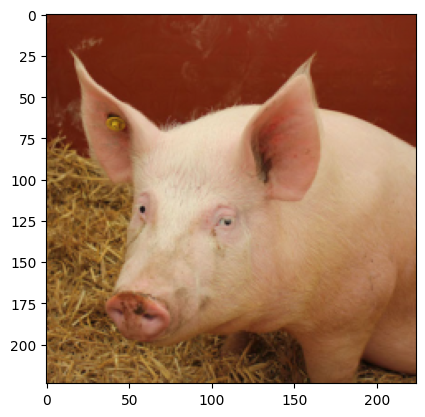

In [47]:
plt.imshow((cat_tensor+delta)[0].detach().numpy().transpose(1,2,0))

# Chapter 2 Linear Models
## Binary Classification

#Chapter 3 Adversarial Examples

## Neural Networks are more bumpy than Linear Models
The Loss Surface of Neural networks are more prone to adversarial attacks
>First, in the high dimensional setting that we will typically consider with deep networks, there is a high likelihood that at almost any point in input space there will be **some direction along the loss surface that is very steep**, i.e., which causes the **loss to either increase or decrease substantially**.
Put another way, neural networks, **by the nature of their loss surfaces**, are
especially prone to adversarial examples.





Text(0, 0.5, 'Output')

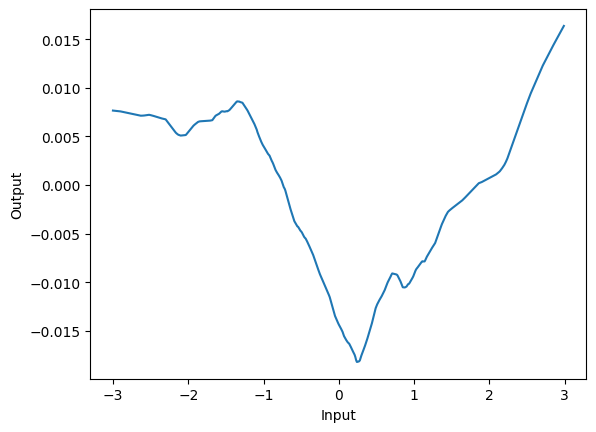

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

torch.manual_seed(0)
model = nn.Sequential(nn.Linear(1,100), nn.ReLU(),
                      nn.Linear(100,100), nn.ReLU(),
                      nn.Linear(100,100), nn.ReLU(),
                      nn.Linear(100,1))
opt = optim.SGD(model.parameters(),lr=1e-2)
for _ in range(100):
    loss = nn.MSELoss()(model(torch.randn(100,1)), torch.randn(100,1))
    opt.zero_grad()
    loss.backward()
    opt.step()

plt.plot(np.arange(-3,3,0.01), model(torch.arange(-3,3,0.01)[:,None]).detach().numpy())
plt.xlabel("Input")
plt.ylabel("Output")

In [18]:
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

model_dnn_2 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(),
                            nn.Linear(200,10)).to(device)

model_dnn_4 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(),
                            nn.Linear(200,100), nn.ReLU(),
                            nn.Linear(100,100), nn.ReLU(),
                            nn.Linear(100,10)).to(device)

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)



100%|██████████| 9912422/9912422 [00:00<00:00, 101453910.93it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24997047.84it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 25736422.29it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17413646.04it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [19]:
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [20]:
opt = optim.SGD(model_dnn_2.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_2, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_2)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.132383	0.517379	0.082800	0.293092
0.075733	0.264427	0.063200	0.223532
0.059017	0.209184	0.053200	0.183879
0.048533	0.172268	0.046500	0.157010
0.041283	0.146382	0.042400	0.141133
0.035467	0.127175	0.036900	0.123717
0.031550	0.112103	0.033700	0.113064
0.027967	0.100139	0.031600	0.104619
0.024683	0.091013	0.030000	0.102942
0.023317	0.082950	0.027900	0.095537


In [21]:
opt = optim.SGD(model_dnn_4.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_4, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_4)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.234450	0.779161	0.078200	0.272526
0.064333	0.218727	0.049600	0.158900
0.042467	0.142951	0.038700	0.125645
0.031883	0.106858	0.030700	0.100219
0.024833	0.084874	0.030000	0.096199
0.020567	0.068036	0.027700	0.086054
0.016883	0.056462	0.026600	0.081215
0.014650	0.046724	0.024800	0.078141
0.011800	0.039429	0.023400	0.073449
0.010017	0.033482	0.021800	0.072171


In [22]:
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.208500	0.620841	0.026600	0.087089
0.024983	0.078836	0.019900	0.061371
0.017400	0.055049	0.013400	0.044272
0.012633	0.040035	0.014900	0.046686
0.009567	0.030449	0.013400	0.037691
0.004183	0.014192	0.010200	0.031722
0.003317	0.011271	0.010100	0.031654
0.002500	0.009930	0.010800	0.032047
0.002317	0.008980	0.010800	0.031999
0.001933	0.008185	0.010500	0.032982


## Fast Gradient Sign Method
Create Adversarial Examples from by transforming image in the gradient by adding noise in the direction of it

In [23]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

In [24]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

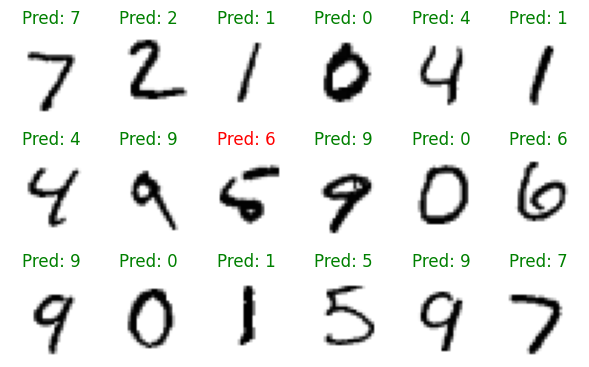

In [25]:
## Original Predictions
yp = model_dnn_2(X)
plot_images(X, y, yp, 3, 6)

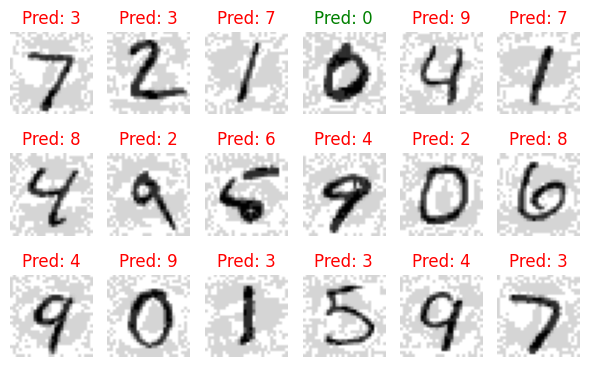

In [26]:
## Adversarial Images

delta = fgsm(model_dnn_2, X, y, 0.1)
yp = model_dnn_2(X + delta)
plot_images(X+delta, y, yp, 3, 6)

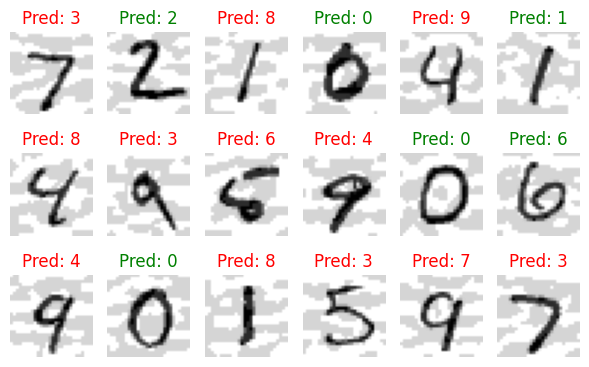

In [33]:
## Attack on CNN
delta = fgsm(model_cnn, X, y, 0.1)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [34]:
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [35]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, fgsm, 0.1)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, fgsm, 0.1)[0])
print("        CNN:", epoch_adversarial(model_cnn, test_loader, fgsm, 0.1)[0])

2-layer DNN: 0.9133
4-layer DNN: 0.9338
        CNN: 0.4444


### Summary of FGSM


1.   FGSM is just a single projected gradient descent step
2.  FGSM is exactly the optimal attack against a linear binary classification model under the ℓ∞ norm.
3.  it assumes that the linear approximation of the hypothesis given by its gradient at the point x is a reasonably good approximation to the function over the entire region




## Projected Gradient Descent
To Maximinze the inner optimization problem
>the basic PGD algorithm simply iterates the updates.
Repeat:δ:=P(δ+α∇δℓ(hθ(x+δ),y))
where P denotes the projection onto the ball of interest (for example, clipping in the case of the ℓ∞ norm)


In [30]:
def pgd(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

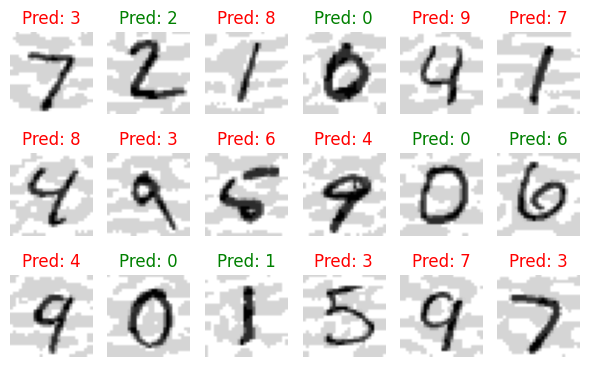

In [31]:
# PGD on CNN
delta = pgd(model_cnn, X, y, 0.1, 1e4, 1000)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [32]:
delta = torch.zeros_like(X, requires_grad=True)
loss = nn.CrossEntropyLoss()(model_cnn(X + delta), y)
loss.backward()
print(delta.grad.abs().mean().item())

1.4997582184150815e-05


# Chapter 4 Adversarial Training

There are two approaches for Adverarial Training for optimization problems


1.   Using lower bounds, and examples constructed via local search methods, to train an (empirically) adversarially robust classifier.

2. Using convex upper bounds, to train a provably robust classifier.



## First Method :- Incorporating Adversarial Examples while Training

Basic Idea is to create and incorporate adversarial examples into the training process.
>*the key aspects of adversarial training is incorporate a strong attack into the inner maximization procedure.*

>**projected gradient descent** approaches are the strongest attack that the community has found.


Repeat:
1. Select minibatch B, initialize gradient vector g:=0
2. For each (x,y) in B:
>a. Find an attack perturbation δ⋆ by (approximately) optimizing δ⋆=argmax∥δ∥≤ϵℓ(hθ(x+δ),y)
b. Add gradient at δ⋆g:=g+∇θℓ(hθ(x+δ⋆),y)
3. Update parameters θθ:=θ−α|B|g

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

100%|██████████| 9912422/9912422 [00:00<00:00, 125461964.46it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 123230614.27it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 124163220.76it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19639720.38it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [3]:
torch.manual_seed(0)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

In [4]:
def fgsm(model, X, y, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)

    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [5]:
def epoch(loader, model, opt=None):
    """Standard training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


def epoch_adversarial(loader, model, attack, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, **kwargs)
        yp = model(X+delta) #ADD AVERSARIAL TRAINING
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [37]:
opt = optim.SGD(model_cnn.parameters(), lr=1e-2)
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_cnn, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model_cnn.state_dict(), "model_cnn.pt")

0.001533	0.010400	0.734400
0.001500	0.010100	0.731900
0.001283	0.010100	0.736200
0.001200	0.010600	0.736900
0.001100	0.010600	0.735600
0.000900	0.010600	0.734600
0.000867	0.010500	0.737500
0.000667	0.010600	0.734600
0.000817	0.011100	0.732000
0.000617	0.010800	0.735300


In [38]:
model_cnn_robust = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                                 nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                                 Flatten(),
                                 nn.Linear(7*7*64, 100), nn.ReLU(),
                                 nn.Linear(100, 10)).to(device)

In [39]:
opt = optim.SGD(model_cnn_robust.parameters(), lr=1e-2)
for t in range(10):
    train_err, train_loss = epoch_adversarial(train_loader, model_cnn_robust, pgd_linf, opt)
    test_err, test_loss = epoch(test_loader, model_cnn_robust)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_cnn_robust, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model_cnn_robust.state_dict(), "model_cnn_robust.pt")

0.925517	0.897200	0.897200
0.901483	0.886500	0.886500
0.887633	0.880000	0.885700
0.665683	0.155000	0.383600
0.301350	0.067100	0.215800
0.202583	0.054600	0.178500
0.155217	0.038800	0.137400
0.127950	0.032900	0.114100
0.110750	0.032900	0.105900
0.098583	0.025700	0.089600


### Evaluating the Robust models

In [9]:
print("FGSM: ", epoch_adversarial(test_loader, model_cnn_robust, fgsm)[0])

FGSM:  0.025


In [10]:
print("PGD, 40 iter: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, num_iter=40)[0])

PGD, 40 iter:  0.0272


In [11]:
#smaller steps (finer attacks-small pertubations)
print("PGD, small_alpha: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, num_iter=40, alpha=0.05)[0])

PGD, small_alpha:  0.0271


In [59]:
print("PGD, randomized: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf,
                                             num_iter=40, randomize=True)[0])

PGD, randomized:  0.0287


### Explanation to the loss models

In [40]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D


def draw_loss(model, X, epsilon):
    Xi, Yi = np.meshgrid(np.linspace(-epsilon, epsilon,100), np.linspace(-epsilon,epsilon,100))

    def grad_at_delta(delta):
        delta.requires_grad_(True)
        nn.CrossEntropyLoss()(model(X+delta), y[0:1]).backward()
        return delta.grad.detach().sign().view(-1).cpu().numpy()

    dir1 = grad_at_delta(torch.zeros_like(X, requires_grad=True))
    delta2 = torch.zeros_like(X, requires_grad=True)
    delta2.data = torch.tensor(dir1).view_as(X).to(device)
    dir2 = grad_at_delta(delta2)
    np.random.seed(0)
    dir2 = np.sign(np.random.randn(dir1.shape[0]))

    all_deltas = torch.tensor((np.array([Xi.flatten(), Yi.flatten()]).T @
                              np.array([dir2, dir1])).astype(np.float32)).to(device)
    yp = model(all_deltas.view(-1,1,28,28) + X)
    Zi = nn.CrossEntropyLoss(reduction="none")(yp, y[0:1].repeat(yp.shape[0])).detach().cpu().numpy()
    Zi = Zi.reshape(*Xi.shape)
    #Zi = (Zi-Zi.min())/(Zi.max() - Zi.min())

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ls = LightSource(azdeg=0, altdeg=200)
    rgb = ls.shade(Zi, plt.cm.coolwarm)

    surf = ax.plot_surface(Xi, Yi, Zi, rstride=1, cstride=1, linewidth=0,
                       antialiased=True, facecolors=rgb)

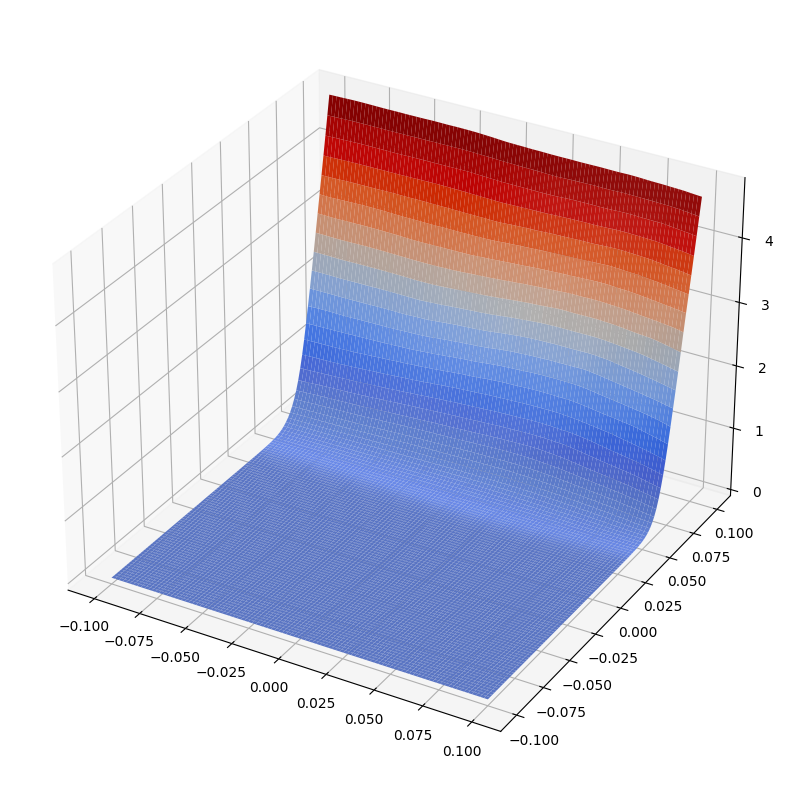

In [42]:
draw_loss(model_cnn,X[0:1],0.1)

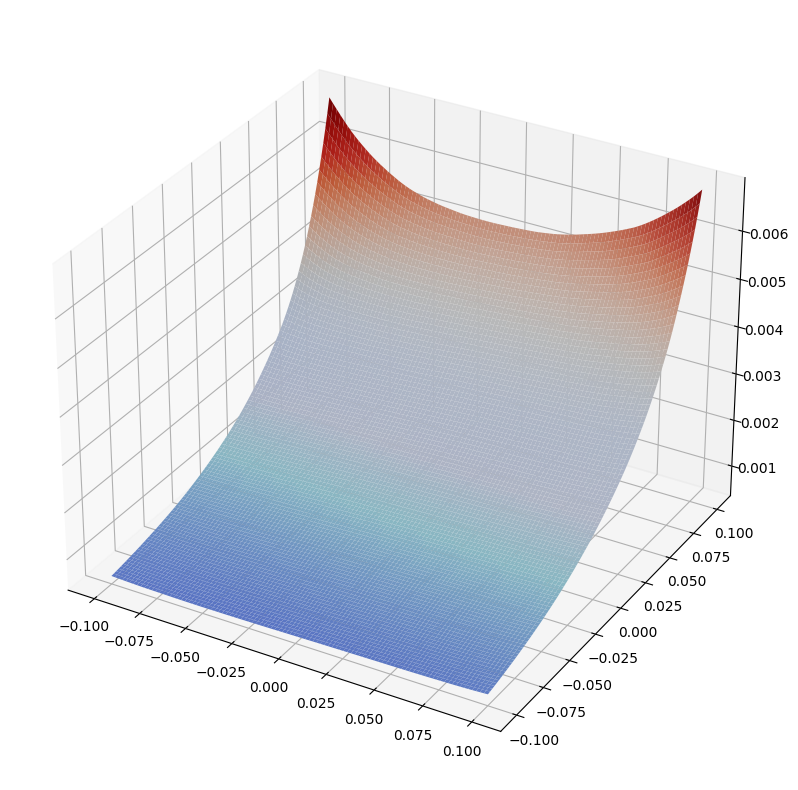

In [43]:
draw_loss(model_cnn_robust,X[0:1],0.1)

## Second Method: Relaxation base robust Training

Convex Relation Methods


In [44]:
def bound_propagation(model, initial_bound):
    l, u = initial_bound
    bounds = []

    for layer in model:
        if isinstance(layer, Flatten):
            l_ = Flatten()(l)
            u_ = Flatten()(u)
        elif isinstance(layer, nn.Linear):
            l_ = (layer.weight.clamp(min=0) @ l.t() + layer.weight.clamp(max=0) @ u.t()
                  + layer.bias[:,None]).t()
            u_ = (layer.weight.clamp(min=0) @ u.t() + layer.weight.clamp(max=0) @ l.t()
                  + layer.bias[:,None]).t()
        elif isinstance(layer, nn.Conv2d):
            l_ = (nn.functional.conv2d(l, layer.weight.clamp(min=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(u, layer.weight.clamp(max=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None,:,None,None])

            u_ = (nn.functional.conv2d(u, layer.weight.clamp(min=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(l, layer.weight.clamp(max=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None,:,None,None])

        elif isinstance(layer, nn.ReLU):
            l_ = l.clamp(min=0)
            u_ = u.clamp(min=0)

        bounds.append((l_, u_))
        l,u = l_, u_
    return bounds


def interval_based_bound(model, c, bounds, idx):
    # requires last layer to be linear
    cW = c.t() @ model[-1].weight
    cb = c.t() @ model[-1].bias

    l,u = bounds[-2]
    return (cW.clamp(min=0) @ l[idx].t() + cW.clamp(max=0) @ u[idx].t() + cb[:,None]).t()


def robust_bound_error(model, X, y, epsilon):
    initial_bound = (X - epsilon, X + epsilon)
    err = 0
    for y0 in range(10):
        C = -torch.eye(10).to(device)
        C[y0,:] += 1
        err += (interval_based_bound(model, C, bounds, y==y0).min(dim=1)[0] < 0).sum().item()
    return err

def epoch_robust_bound(loader, model, epsilon):
    total_err = 0

    C = [-torch.eye(10).to(device) for _ in range(10)]
    for y0 in range(10):
        C[y0][y0,:] += 1

    for X,y in loader:
        X,y = X.to(device), y.to(device)
        initial_bound = (X - epsilon, X + epsilon)
        bounds = bound_propagation(model, initial_bound)
        for y0 in range(10):
            lower_bound = interval_based_bound(model, C[y0], bounds, y==y0)
            total_err += (lower_bound.min(dim=1)[0] < 0).sum().item()
    return total_err / len(loader.dataset)

In [45]:
epoch_robust_bound(test_loader, model_cnn_robust, 0.1)

1.0

In [49]:
epoch_robust_bound(test_loader,model_cnn_robust,0.000001)

0.0258

In [51]:
#Code foe using provable criteria

def epoch_robust_bound(loader, model, epsilon, opt=None):
    total_err = 0
    total_loss = 0

    C = [-torch.eye(10).to(device) for _ in range(10)]
    for y0 in range(10):
        C[y0][y0,:] += 1

    for X,y in loader:
        X,y = X.to(device), y.to(device)
        initial_bound = (X - epsilon, X + epsilon)
        bounds = bound_propagation(model, initial_bound)
        loss = 0
        for y0 in range(10):
            if sum(y==y0) > 0:
                lower_bound = interval_based_bound(model, C[y0], bounds, y==y0)
                loss += nn.CrossEntropyLoss(reduction='sum')(-lower_bound, y[y==y0]) / X.shape[0]
                total_err += (lower_bound.min(dim=1)[0] < 0).sum().item()
        total_loss += loss.item() * X.shape[0]
        #print(loss.item())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [52]:
torch.manual_seed(0)
model_cnn_robust_2 = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1, stride=2), nn.ReLU(),
                                   nn.Conv2d(32, 32, 3, padding=1, ), nn.ReLU(),
                                   nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                   nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                                   Flatten(),
                                   nn.Linear(7*7*64, 100), nn.ReLU(),
                                   nn.Linear(100, 10)).to(device)

In [53]:
opt = optim.SGD(model_cnn_robust_2.parameters(), lr=1e-1)
eps_schedule = [0.0, 0.0001, 0.001, 0.01, 0.01, 0.05, 0.05, 0.05, 0.05, 0.05] + 15*[0.1]

print("Train Eps", "Train Loss*", "Test Err", "Test Robust Err", sep="\t")
for t in range(len(eps_schedule)):
    train_err, train_loss = epoch_robust_bound(train_loader, model_cnn_robust_2, eps_schedule[t], opt)
    test_err, test_loss = epoch(test_loader, model_cnn_robust_2)
    adv_err, adv_loss = epoch_robust_bound(test_loader, model_cnn_robust_2, 0.1)
    #if t == 4:
    #    for param_group in opt.param_groups:
    #        param_group["lr"] = 1e-2

    print(*("{:.6f}".format(i) for i in (eps_schedule[t], train_loss, test_err, adv_err)), sep="\t")
torch.save(model_cnn_robust_2.state_dict(), "model_cnn_robust_2.pt")

Train Eps	Train Loss*	Test Err	Test Robust Err
0.000000	0.831852	0.029900	1.000000
0.000100	0.126948	0.023200	1.000000
0.001000	0.124424	0.019600	1.000000
0.010000	0.306235	0.026900	1.000000
0.010000	0.152684	0.023700	1.000000
0.050000	2.312470	0.886500	0.887100
0.050000	2.301517	0.886500	0.886900
0.050000	2.301415	0.886500	0.886800
0.050000	2.301492	0.886500	0.886900
0.050000	2.301406	0.886500	0.886900
0.100000	2.301600	0.886500	0.886600
0.100000	2.301439	0.886500	0.886600
0.100000	2.301516	0.886500	0.886600
0.100000	2.301504	0.886500	0.886600
0.100000	2.301474	0.886500	0.886600
0.100000	2.301405	0.886500	0.886600
0.100000	2.301454	0.886500	0.886600
0.100000	2.301420	0.886500	0.886600
0.100000	2.301400	0.886500	0.886600
0.100000	2.301476	0.886500	0.886600
0.100000	2.301514	0.886500	0.886600
0.100000	2.301446	0.886500	0.886600
0.100000	2.301488	0.886500	0.886600
0.100000	2.301423	0.897200	0.897300
0.100000	2.301466	0.886500	0.886600


In [54]:
print("PGD, 40 iter: ", epoch_adversarial(test_loader, model_cnn_robust_2, pgd_linf, num_iter=40)[0])

PGD, 40 iter:  0.8865
